<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/deagwon/Dacon_satellite_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

In [85]:
tf.__version__

'2.2.0-rc3'

## 데이터 받아오기

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [0]:
# 훈련 데이터 및 자가 test데이터 불러오기
train = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_add.npy')
train_orbit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/orbit_no_shuffle/train_orbit.npy')
#test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/32bits_data/test_32bits.npy')

In [88]:
train.shape

(76345, 40, 40, 15)

In [89]:
index = np.arange(train.shape[0])

np.random.shuffle(index)
train = train[index,:,:,:]
gc.collect()
train.shape
train_orbit = train_orbit[index,:]
gc.collect()
train_orbit.shape

(76345, 2)

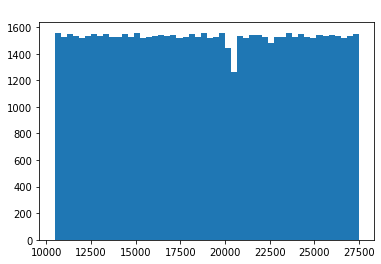

'\n모든 orbit속 이미지 숫자가 동일하지 않음, 2개(?)의 orbit에서 다른 orbit보다 적은 수의 이미지가 존재.\n날짜 데이터로 변환할 때 이를 고려할것.\n'

In [90]:
plt.hist(train_orbit[:,0], bins = 50)
plt.title('The Number of images in each orbits', color = 'white')
plt.show()

##
'''
모든 orbit속 이미지 숫자가 동일하지 않음, 2개(?)의 orbit에서 다른 orbit보다 적은 수의 이미지가 존재.
날짜 데이터로 변환할 때 이를 고려할것.
'''


In [0]:
train_orbit = pd.DataFrame(train_orbit)

In [92]:
train_orbit.reset_index()

,index,0,1
0,0,26666,1
1,1,25454,9
2,2,18779,4
3,3,20100,11
4,4,21197,1
...,...,...,...
76340,76340,22410,12
76341,76341,12845,2
76342,76342,21575,10
76343,76343,23562,2


In [0]:
train_orbit['year'] = 0
train_orbit.loc[train_orbit[0]<=16152,'year'] = 2016
train_orbit.loc[(16152 <= train_orbit[0]) & (train_orbit[0] <= 21828), 'year'] = 2017
train_orbit.loc[(21828 < train_orbit[0]) & (train_orbit[0] <= 27509), 'year'] = 2018

In [94]:
train_orbit.year.value_counts()

2016    25650
2018    25495
2017    25200
Name: year, dtype: int64

In [0]:
train_orbit['month'] = 0
train_orbit.loc[train_orbit.loc[:,'year'] == 2016,'month'] = ((16152 - train_orbit.loc[train_orbit.loc[:,'year'] == 2016,0])/(16152 - 10462) * 12)
train_orbit.loc[train_orbit.loc[:,'year'] == 2017,'month'] = ((21828 - train_orbit.loc[train_orbit.loc[:,'year'] == 2017,0])/(21828 - 16152) * 12)
train_orbit.loc[train_orbit.loc[:,'year'] == 2018,'month'] = ((27509 - train_orbit.loc[train_orbit.loc[:,'year'] == 2018,0])/(27509 - 21828) * 12)

train_orbit.month = train_orbit.month.astype('int16')

(array([6431., 6376., 6244., 6193., 6389., 6410., 6370., 6424., 6376.,
        6399., 6350., 6383.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 <a list of 12 Patch objects>)

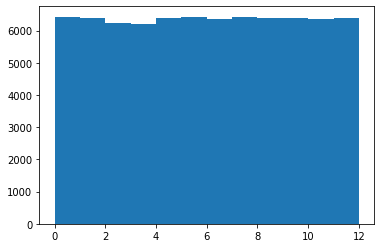

In [107]:
plt.hist(train_orbit.month, bins = 12)

In [0]:
train_orbit.month.value_counts()

## 시각화 하기

In [0]:
import seaborn as sns

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [0]:
image_sample = train[1223]

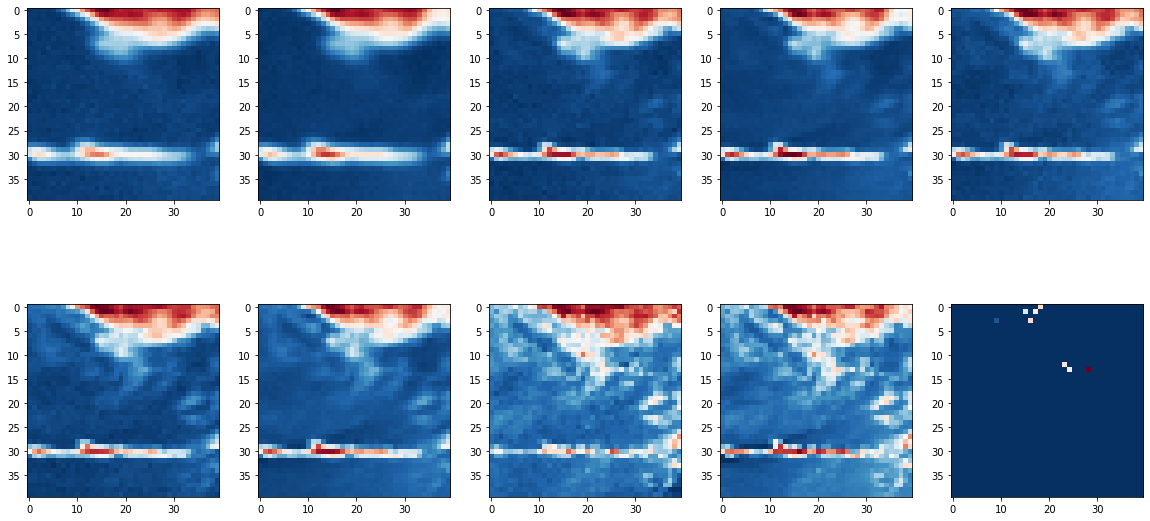

In [0]:
plt.style.use('seaborn-colorblind')
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [0]:
image_sample.shape

(40, 40, 15)

# 픽셀 단위로 EDA
Pandas 를 사용할 경우 메모리 초과  
numpy로 진행

특히 scatterplot을 그릴 때 메모리 소비가 증가하므로, 하나씩 그리기  
그래도 안되서 데이터 타입을 np.float16으로 변경

In [0]:
# style 설정
plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

In [134]:
train_numeric = np.zeros((train.shape[0] * 40 * 40 ,5), np.float16)
train_numeric[:,0] = train[:,:,:,9].reshape(-1) # land type
train_numeric[:,1] = train[:,:,:,10].reshape(-1) # GMI longitude
train_numeric[:,2] = train[:,:,:,11].reshape(-1) # GMI latitude
train_numeric[:,3] = train[:,:,:,14].reshape(-1) #  precipication
train_numeric[train_numeric[:,3]<0,3]= 0## Null값은 모두 0으로 초기화

for i,month in enumerate(train_orbit.month.values):
    train_numeric[i*1600 : (i+1)*1600,4]  = month # Month


gc.collect()

28

In [135]:
#eda에 불필요한 train은 제거
del train
gc.collect()

0

### Precipitation vs GMI_latitude

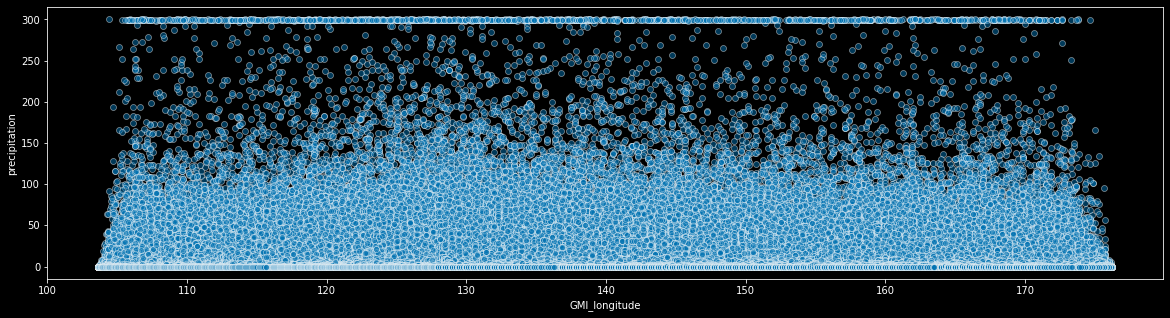

2515

In [0]:
plt.figure(figsize = (20,5))
sns.scatterplot(train_numeric[:,1],train_numeric[:,3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('GMI_longitude')
plt.show()
gc.collect()

### Precipitation vs GMI_longitude

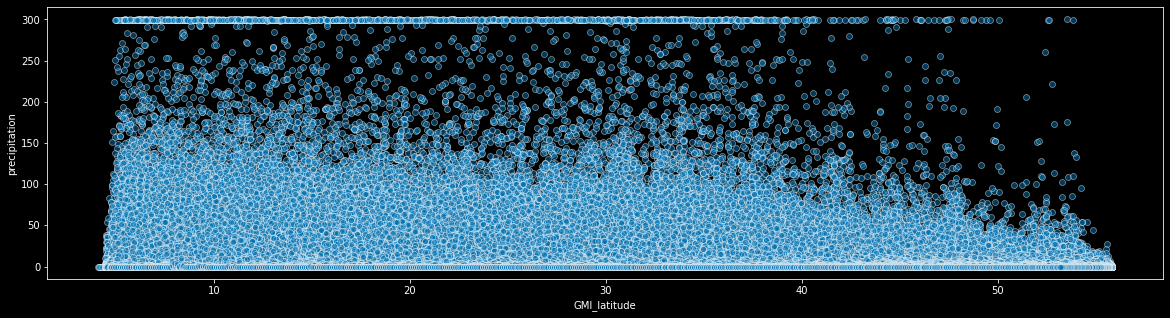

2341

In [0]:
plt.figure(figsize = (20,5))
sns.scatterplot(train_numeric[:,2],train_numeric[:,3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('GMI_latitude')
plt.show()
gc.collect()

### Precipitation vs Land type

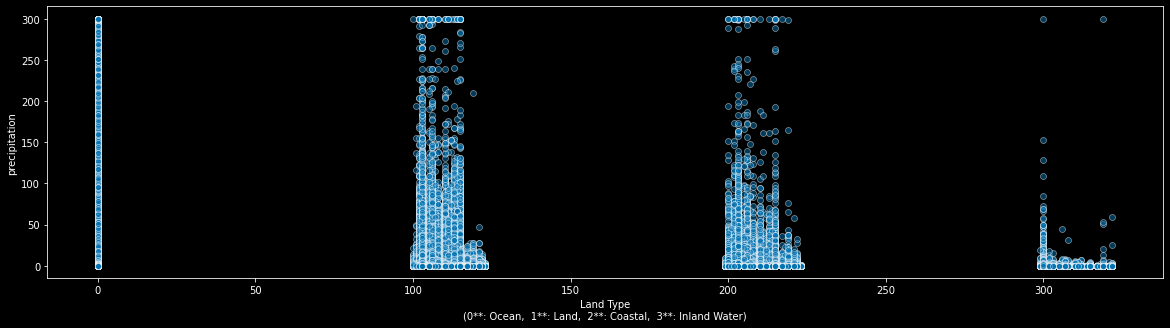

2457

In [110]:
plt.figure(figsize = (20,5))
sns.scatterplot(train_numeric[:,0],train_numeric[:,3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('Land Type\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)')
plt.show()
gc.collect()

### land_type별 강수 비율을 시각화
1. ladn_type ( 0 ~ 100, 100 ~ 200, 200 ~ 300, 300 ~) 으로 나누기
2. 강수구간 (0 ~ 50, 50 ~ 100, 100 ~ 150, 150 ~ 200, 250 ~ 300) 5개의 band로 묶기
3. (강수구간의 count / land_type count) * 100 계산하기
4. heatmap으로 표현하기

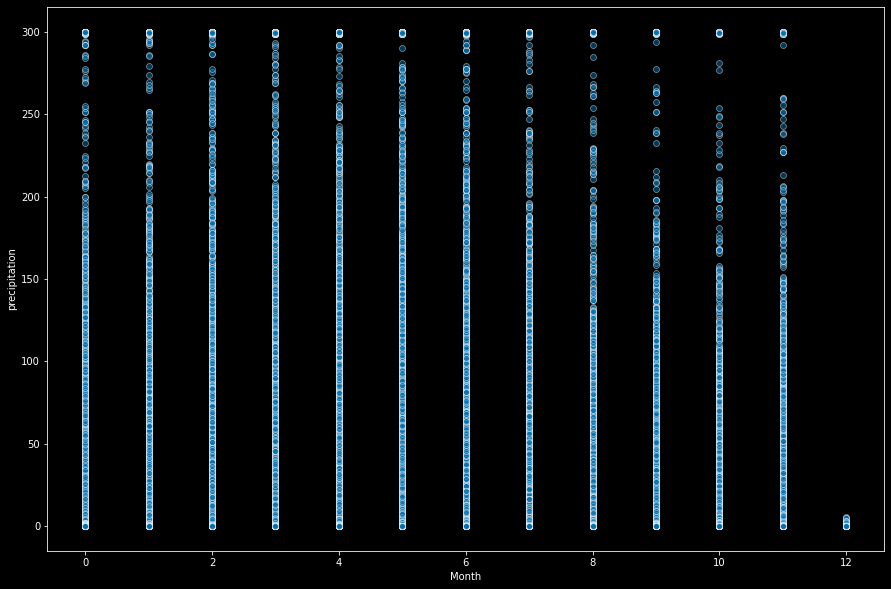

3125

In [122]:
plt.figure(figsize = (15,10))
sns.scatterplot(train_numeric[:,4],train_numeric[:,3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('Month')
plt.show()
gc.collect()

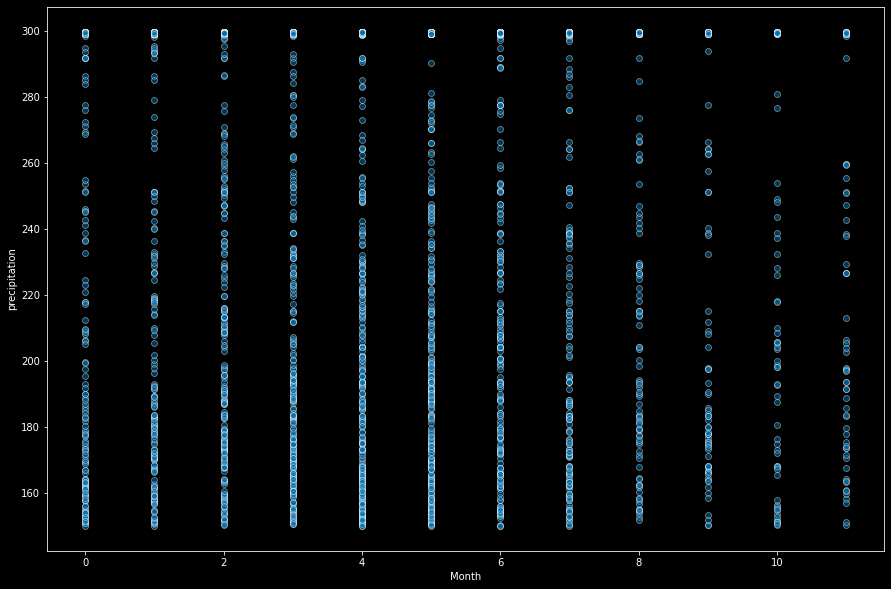

2457

In [153]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = train_numeric[((train_numeric[:,3] > 150) & (train_numeric[:,3] < 300)), 4], y = train_numeric[((train_numeric[:,3] > 150) & (train_numeric[:,3] < 300)), 3], alpha = 0.5)
plt.ylabel('precipitation')
plt.xlabel('Month')
plt.show()
gc.collect()

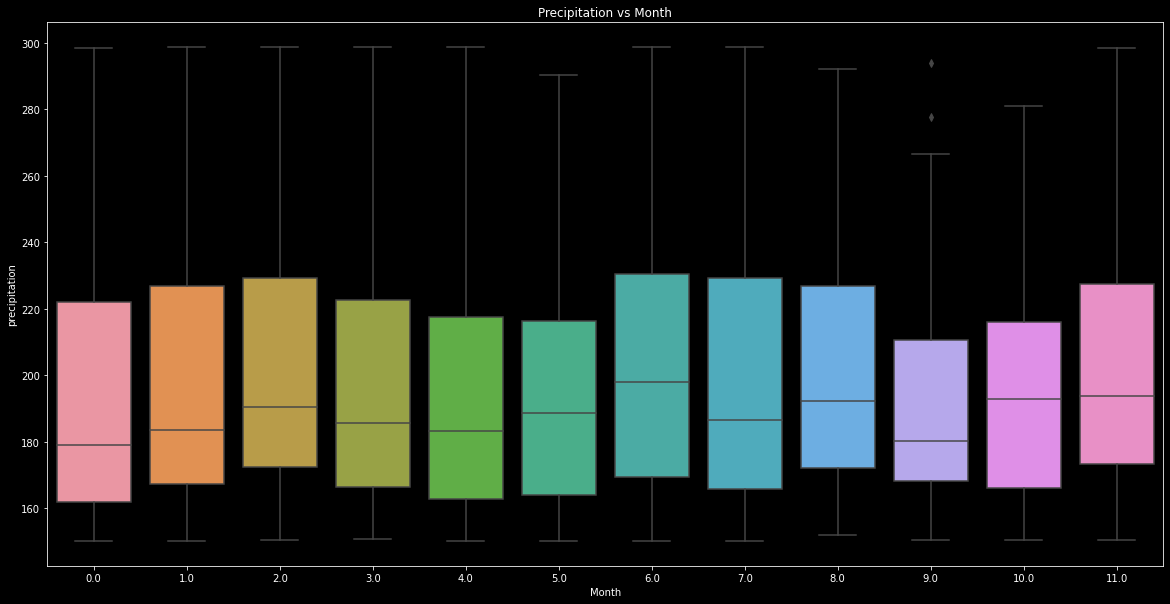

8638

In [156]:
plt.figure(figsize = (20,10))
sns.boxplot(x = train_numeric[((train_numeric[:,3] > 150) & (train_numeric[:,3] < 299)), 4], y = train_numeric[((train_numeric[:,3] > 150) & (train_numeric[:,3] < 299)), 3])
plt.ylabel('precipitation')
plt.xlabel('Month')
plt.title('Precipitation vs Month')
plt.show()
gc.collect()

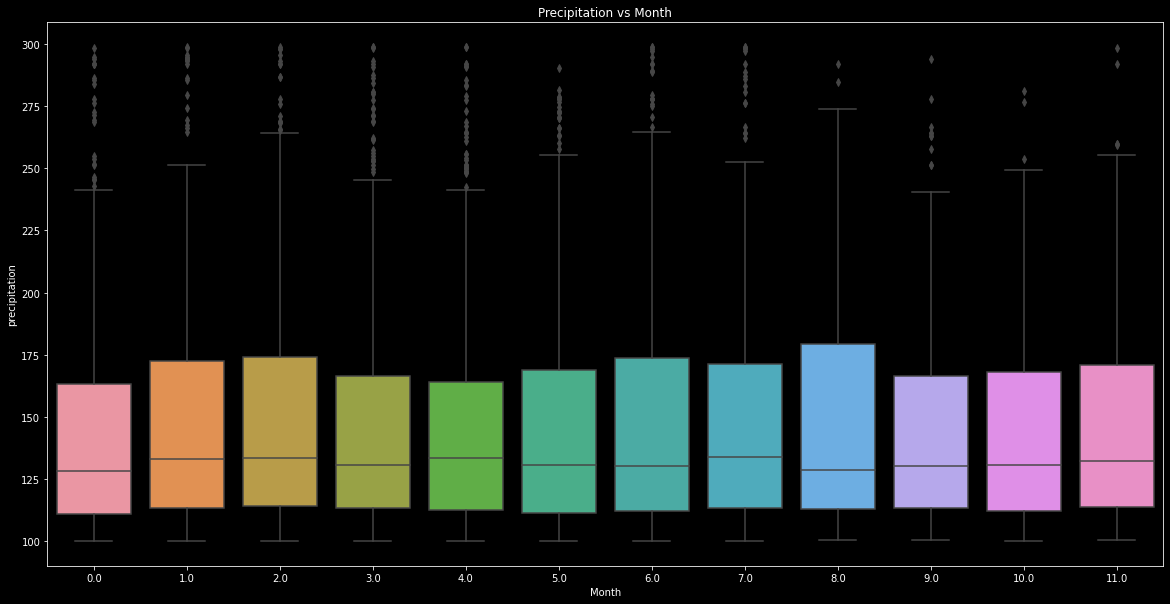

8696

In [157]:
plt.figure(figsize = (20,10))
sns.boxplot(x = train_numeric[((train_numeric[:,3] > 100) & (train_numeric[:,3] < 299)), 4], y = train_numeric[((train_numeric[:,3] > 100) & (train_numeric[:,3] < 299)), 3])
plt.ylabel('precipitation')
plt.xlabel('Month')
plt.title('Precipitation vs Month')
plt.show()
gc.collect()

### Feature별 histogram 그리기

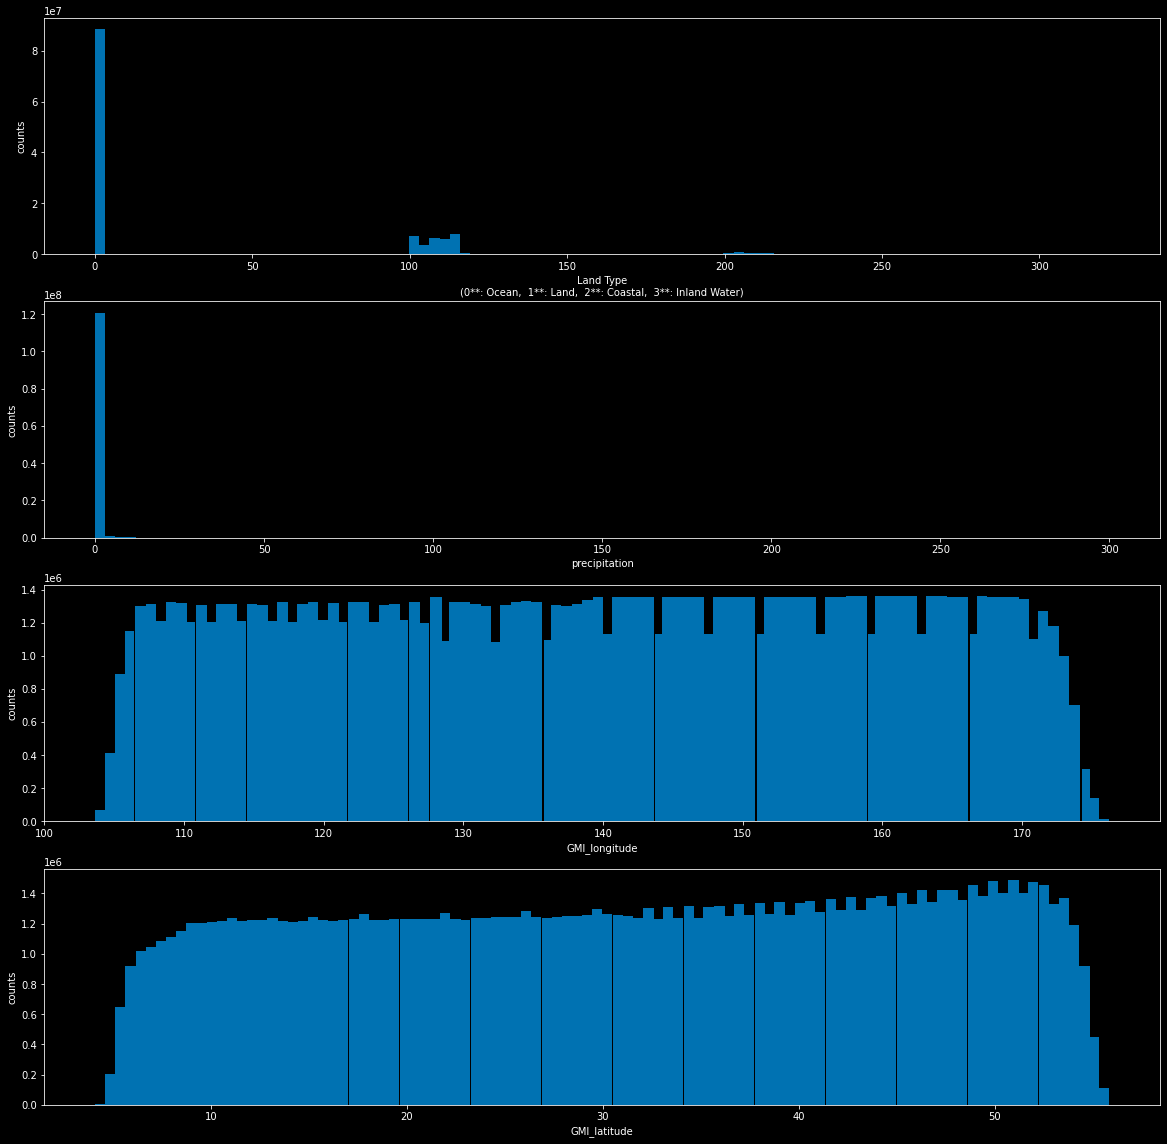

36114

In [0]:
plt.figure(figsize = (20,20))

plt.subplot(4,1,1)
plt.hist(train_numeric[:,0], bins = 100)
#plt.ylim(0,2.0e7)
plt.ylabel('counts')
plt.xlabel('Land Type\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)')

plt.subplot(4,1,2)
plt.hist(train_numeric[:,3], bins = 100)
#plt.ylim(0,0.1e8)
plt.ylabel('counts')
plt.xlabel('precipitation')

plt.subplot(4,1,3)
plt.hist(train_numeric[:,1], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_longitude')

plt.subplot(4,1,4)
plt.hist(train_numeric[:,2], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_latitude')

plt.show()
gc.collect()

### Feature별 histogram 그리기 ylim 조정

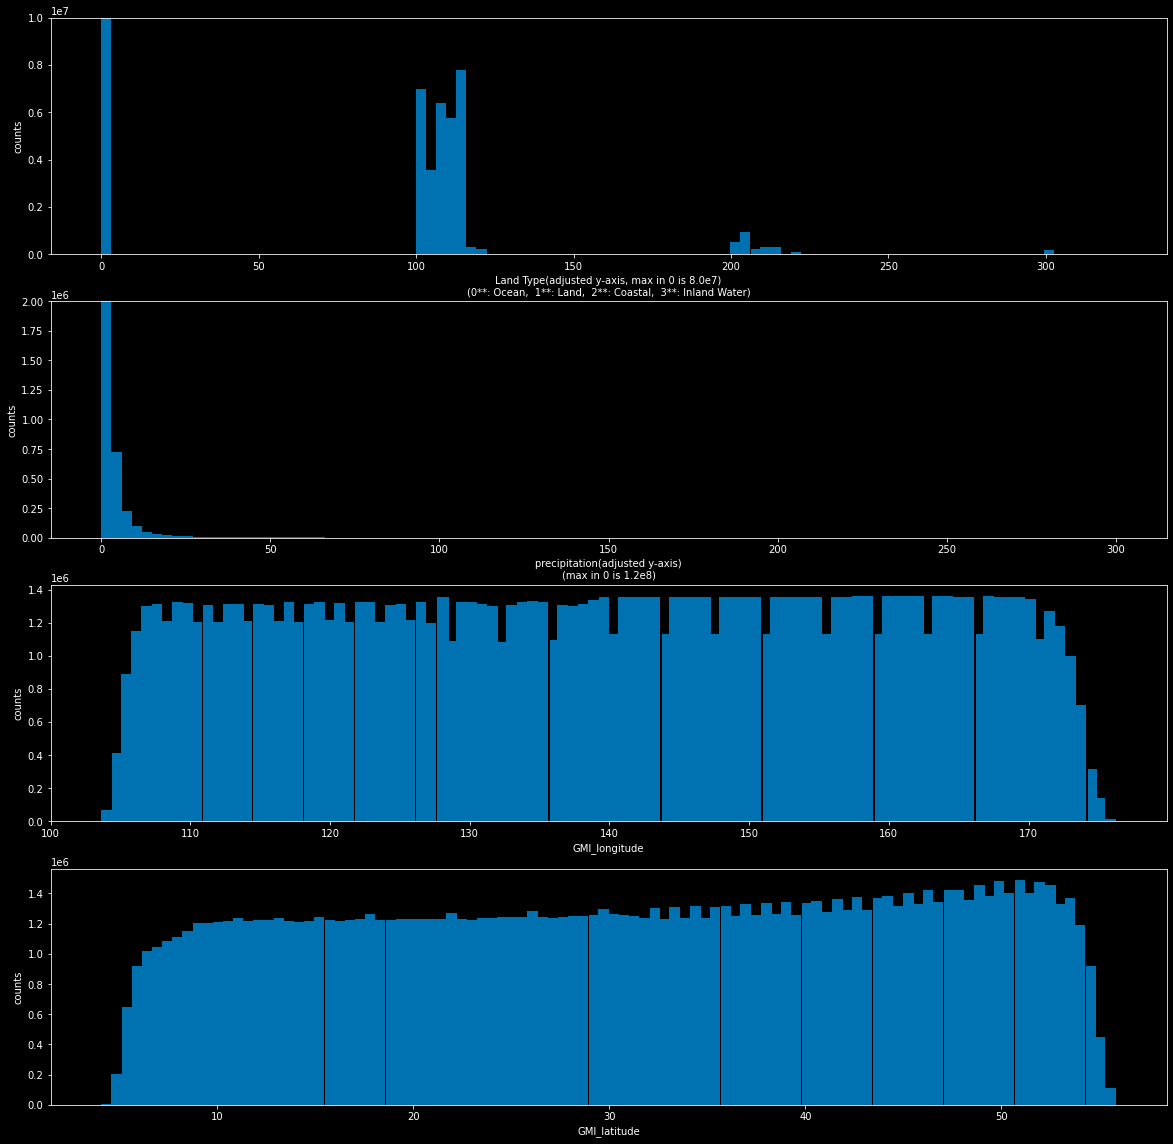

36203

In [0]:
plt.figure(figsize = (20,20))

plt.subplot(4,1,1)
plt.hist(train_numeric[:,0], bins = 100)
plt.ylim(0,1.0e7)
plt.ylabel('counts')
plt.xlabel('Land Type(adjusted y-axis, max in 0 is 8.0e7)\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)')

plt.subplot(4,1,2)
plt.hist(train_numeric[:,3], bins = 100)
plt.ylim(0,0.02e8)
plt.ylabel('counts')
plt.xlabel('precipitation(adjusted y-axis)\n(max in 0 is 1.2e8)')

plt.subplot(4,1,3)
plt.hist(train_numeric[:,1], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_longitude')

plt.subplot(4,1,4)
plt.hist(train_numeric[:,2], bins = 100)
plt.ylabel('counts')
plt.xlabel('GMI_latitude')

plt.show()
gc.collect()

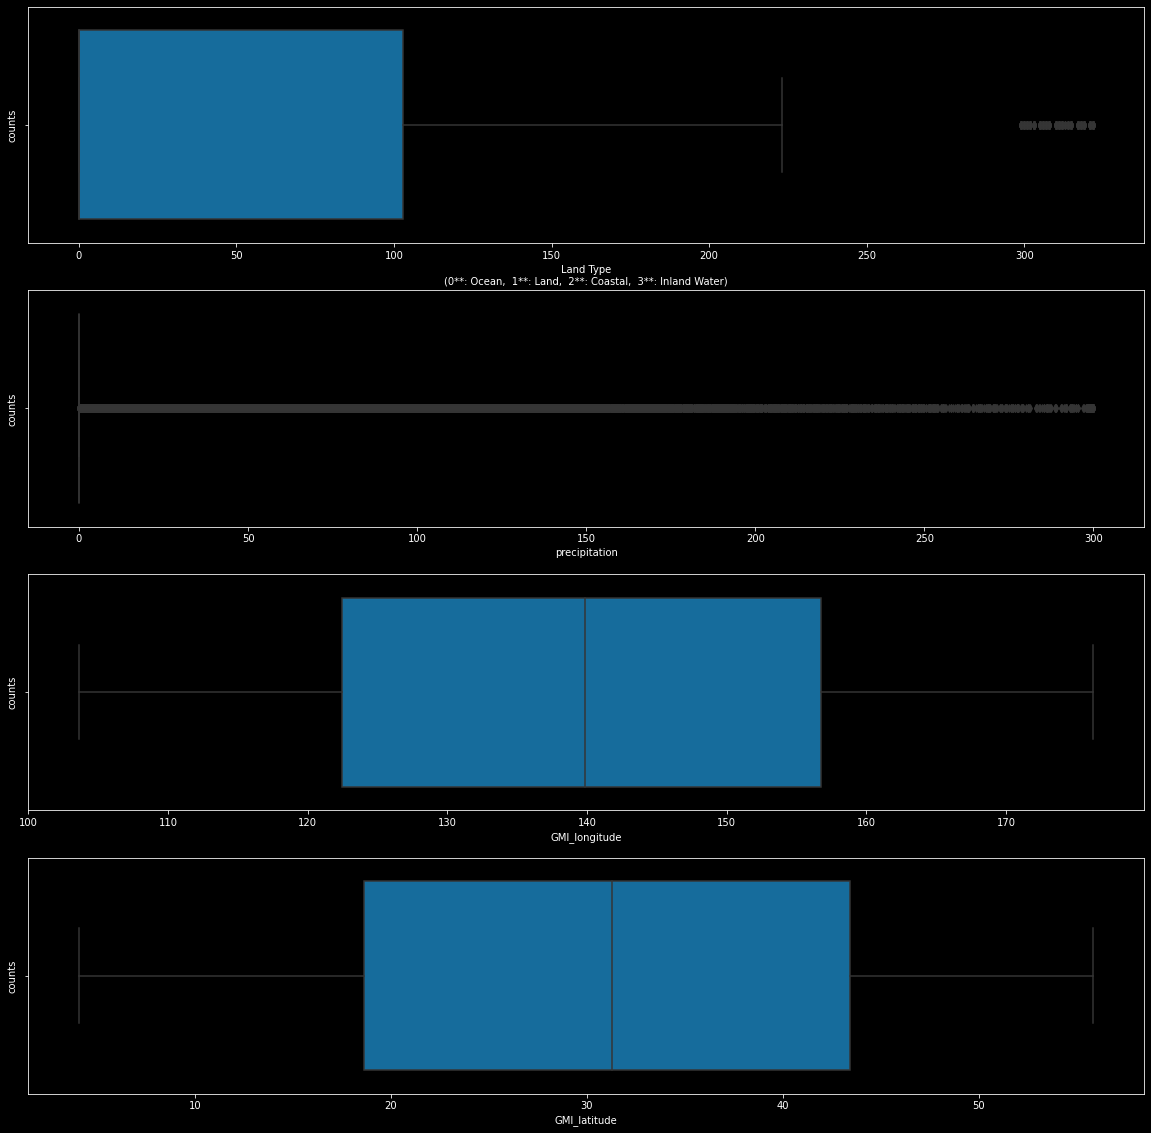

9518

In [0]:
plt.figure(figsize = (20,20))

plt.subplot(4,1,1)
sns.boxplot(x = train_numeric[:,0])
#plt.ylim(0,2.0e7)
plt.ylabel('counts')
plt.xlabel('Land Type\n(0**: Ocean,  1**: Land,  2**: Coastal,  3**: Inland Water)')

plt.subplot(4,1,2)
sns.boxplot(x = train_numeric[:,3])
#plt.ylim(0,0.1e8)
plt.ylabel('counts')
plt.xlabel('precipitation')

plt.subplot(4,1,3)
sns.boxplot(x = train_numeric[:,1])
plt.ylabel('counts')
plt.xlabel('GMI_longitude')

plt.subplot(4,1,4)
sns.boxplot(x = train_numeric[:,2])
plt.ylabel('counts')
plt.xlabel('GMI_latitude')

plt.show()
gc.collect()

Text(0.5, 1.0, 'Satellite map')

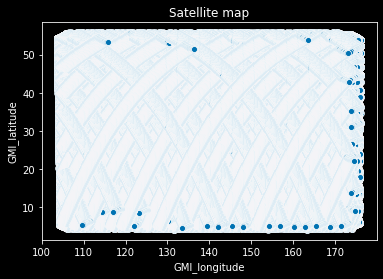

In [0]:
sns.scatterplot(train_numeric[:,1],train_numeric[:,2], alpha = 0.3)
plt.xlabel('GMI_longitude')
plt.ylabel('GMI_latitude')
plt.title('Satellite map')

In [0]:
!apt install proj-bin libproj-dev libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
!pip install https://github.com/matplotlib/basemap/archive/master.zip
from mpl_toolkits.basemap import Basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev proj-bin
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 305 kB of archives.
After this operation, 1,706 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 305 kB in 1s (426 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Selecting previously unselected package libproj-dev:amd64.
Prepari

     |████████████████████████████████| 133.1MB 31kB/s 
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756017 sha256=21104b24580734a1877f0eb2e227b5680a9376d98fb626902f6216ca050bbf71
  Stored in directory: /tmp/pip-ephem-wheel-cache-ng17en8p/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
  Found existing installation: basemap 1.1.0
    Uninstalling basemap-1.1.0:
      Successfully uninstalled basemap-1.1.0


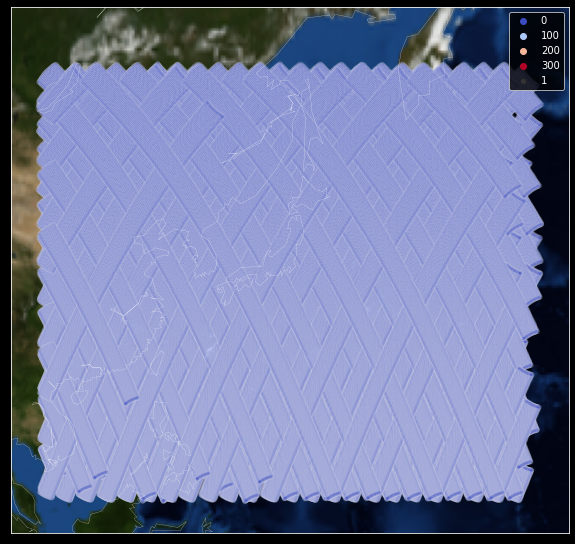

In [0]:
from mpl_toolkits.basemap import Basemap

gc.collect()
## 전체 데이터 지도위에 그리기
plt.figure(figsize = (10,10))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(train_numeric[:2000000,1], train_numeric[:2000000,2])  # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train_numeric[:2000000,3], # 크기는 Precipitation
                     palette=cmap,
                     size = 1,
                     #size=train_numeric_rain.precipitation, 
                     alpha = 0.1,
                     edgecolor = None
                     )
plt.show()


In [0]:
#강수 데이터 지도 위에 그리기
train_numeric_rain = train_numeric[(train_numeric[:,3] > 4)]
train_numeric_rain = train_numeric_rain[(train_numeric_rain[:,3] < 7)] 
train_numeric_rain.shape

(471098, 4)

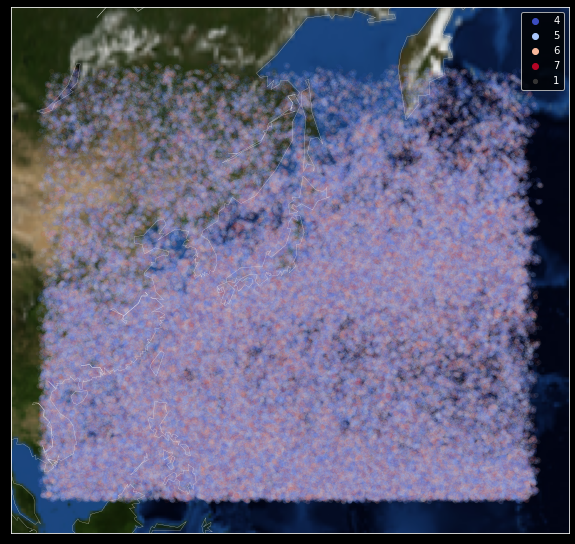

In [0]:

plt.figure(figsize = (10,10))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
x, y = m(train_numeric_rain[:,1], train_numeric_rain[:,2])  # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     hue=train_numeric_rain[:,3], # 색깔은 Land type
                     palette=cmap,
                     size = 1,
                     #size=train_numeric_rain.precipitation, # 크기는 Precipitation
                     alpha = 0.05,
                     edgecolor = None
                     )
plt.show()

In [0]:
train[1,0,:,11]

In [0]:
train_numeric_rain = train_numeric[train_numeric['precipitation'] > 2]
gc.collect()

plt.figure(figsize = (10,10))
fig = plt.gcf()

m = Basemap(projection='merc', \
            llcrnrlat=0, urcrnrlat=60, \
            llcrnrlon=100, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

m = Basemap(projection='lcc', resolution='c',
            width=8E6, height=8E6, 
            lat_0=45, lon_0=-100,)


x, y = m(train[1,0,:,10], train[1,0,:,11])   # transform coordinates

cmap = 'coolwarm'
ax = sns.scatterplot(x=x, y=y,
                     #hue=train_numeric_rain.land_type.values, # 색깔은 Land type
                     palette = cmap,
                     sizes=(1, 2000),
                     color = 'red',
                     size=2000,
                     alpha = 1
                     )

plt.show()

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 10))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
model_history = []
fold_number = 0

for train_index, test_index in kf.split(train):
    print(f'\nFold {fold_number}')
    fold_number = fold_number + 1
    
#-----------------------------------------------------------------------------
    def trainGenerator():
        for file in train[train_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
#-----------------------------------------------------------------------------
    def testGenerator():
        for file in train[test_index]:
            target= file[:,:,-1].reshape(40,40,1)
            cutoff_labels = np.where(target < 0, 0, target)
            feature = file[:,:,:10]#########################land type 추가
            if (cutoff_labels > 0).sum() < 50:
                continue
            yield (feature, cutoff_labels)
    test_dataset = tf.data.Dataset.from_generator(testGenerator,
                                                (tf.float32, tf.float32),
                                                (tf.TensorShape([40,40,10]),########################land type 추가
                                                    tf.TensorShape([40,40,1])))
    test_size = len(test_index)
    test_dataset = test_dataset.batch(test_size).prefetch(1)
#-----------------------------------------------------------------------------

    
    
    history = model.fit(train_dataset, epochs = 10, verbose=1, validation_data = test_dataset)

    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    #del data
    del train_dataset
    del test_dataset
    gc.collect()


Fold 0
Epoch 1/10
44/44 [==============================] - 42s 945ms/step - loss: 0.4592 - maeOverFscore_keras: 6.3886 - fscore_keras: 0.3527 - val_loss: 0.2905 - val_maeOverFscore_keras: 4.0041 - val_fscore_keras: 0.4712
Epoch 2/10
44/44 [==============================] - 38s 853ms/step - loss: 0.3020 - maeOverFscore_keras: 3.2665 - fscore_keras: 0.5533 - val_loss: 0.2853 - val_maeOverFscore_keras: 3.6380 - val_fscore_keras: 0.5103
Epoch 3/10
44/44 [==============================] - 37s 850ms/step - loss: 0.2880 - maeOverFscore_keras: 3.0440 - fscore_keras: 0.5790 - val_loss: 0.2814 - val_maeOverFscore_keras: 3.3206 - val_fscore_keras: 0.5494
Epoch 4/10
44/44 [==============================] - 37s 843ms/step - loss: 0.2773 - maeOverFscore_keras: 2.7557 - fscore_keras: 0.6168 - val_loss: 0.3065 - val_maeOverFscore_keras: 4.5501 - val_fscore_keras: 0.4434
Epoch 5/10
44/44 [==============================] - 37s 848ms/step - loss: 0.2692 - maeOverFscore_keras: 2.5503 - fscore_keras: 0.64

In [0]:
## 모델 저장하기
model.save('model_landtype.h5')
!cp model_landtype.h5 '/content/drive/My Drive/2020 Kaggle Study/model'

In [0]:
def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['maeOverFscore_keras'], label='maeOverFscore_keras')
    plt.plot(np.arange(0, epoch), his.history['val_maeOverFscore_keras'], label='val_maeOverFscore_keras')
    plt.title(title)
    plt.xlabel(f'Epoch {epoch}')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

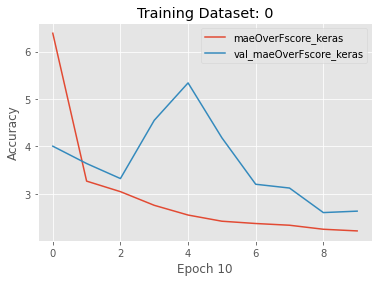

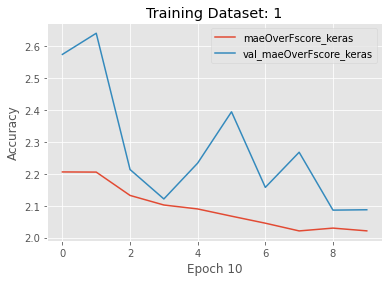

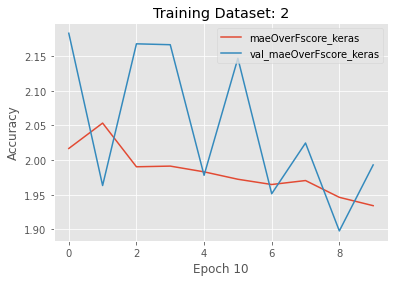

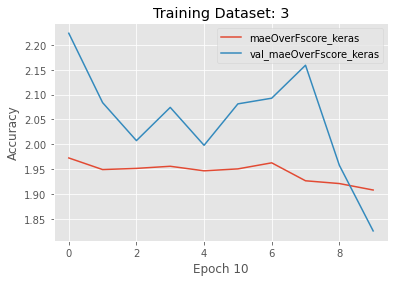

In [0]:
for dataset in range(4):
    #plot_loss(model_history[dataset], 10 , f'Training Dataset: {dataset}')
    plot_acc(model_history[dataset], 10 , f'Training Dataset: {dataset}')


## submission 만들기

In [0]:
# 훈련에서 사용하는 0~8번 채널, ladtype 만을 뽑아서 X_test에 저장하기
test_submit = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')
test_submit = test_submit[:,:,:,:10]
del test_submit
gc.collect()
pred = model.predict(test_submit)

## submission 만들기

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_landtype.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_landtype.csv '/content/drive/My Drive/2020 Kaggle Study/submission'